<a href="https://colab.research.google.com/github/Jaewon45/ESAA_2022/blob/main/0919_Training_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4. 모델훈련

- 모델과 알고리즘의 작동원리와 상세사항에 대한 이해
 - 적절한 모델, 올바른 훈련알고리즘, 작업에 맞는 하이퍼파라미터를 빠르게 찾을 수 있음
 - 디버깅이나 에러를 효율적으로 분석할 수 있음

#### 개요
- 선형회귀 모델 훈련 방법
 1. 직적 계산할 수 있는 공식을 사용해 훈련 세트에 가장 잘 맞는 모델 파라미터를 해석적으로 구함
 2. 경사하강법(GD)라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화시킴 (배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법)
- 비선형 데이터셋에 훈련시킬 수 있는 다항회귀 모델
 - 선형회귀보다 파라미터가 많아서 훈련 데이터에 과대적합되기 더 쉬움
 - 학습곡선 (learning curve)을 사용해 모델이 과대적합되는지 감지
 - 훈련 세트의 과대적합을 감소시킬 수 있는 규제기법의 종류
- 분류 작업에 널리 사용하는 모델인 로지스틱회귀와 소프트맥스 회귀

## 4.1 선형회귀
- 선형 회귀 모델의 예측 :  $ \hat y = θ_0+θ_1x_1+...+θ_nx_n$
- 선형 회귀 모델의 예측 (벡터형태) :  $ \hat y = h_\theta (x) = θ·x $
 - $\theta$ : 편향 $\theta_0$에서 $\theta_n$까지의 특성 가중치를 담은 모델의 파라미터 벡터
 - $x$ : 편향 $x_0$에서 $x_n$까지 담은 샘플의 특성 벡터. **$x_0$는 항상 1**
 - $h_\theta (x)$는 모델 파라미터 $\theta$를 사용한 가설 함수
- 선형회귀모델을 훈련시키려면 RMSE를 최소화하는 $\theta$를 찾아야 함. 실제로는 MSE를 최소화하는 것이 같은 결과를 내면서 더 간단함
- 선형 회귀 모델의 MSE 비용 함수 : $MSE(X, h_\theta) = \frac {1}{m}$$\sum_{i=1}^m$$( \theta^Tx^{(i)}-y^{(i)})^2$

### 4.1.1 정규방정식
- 정규방정식 : $ \hat \theta = (X^TX)^{-1}X^Ty$
 - 비용함수를 최소화하는 $\theta$값을 찾기 위한 해석적인 방법 
 - y는 $y^{(1)}$부터 $y^{(m)}$까지 포함하는 타깃 벡터


In [1]:
# 선형처럼 보이는 데이터 무작위 생성
import numpy as np

X = 2*np.random.rand(100,1)
y = 4 + 3*X + np.random.randn(100,1) # 상수항 : 가우시안 잡음

In [2]:
X_b = np.c_[np.ones((100,1)), X] # 모든 샘플에 x0 = 1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [3]:
theta_best

array([[4.30972087],
       [2.67468962]])

- 기대한 값은 $\theta_0$=4, $\theta_1$=3
- 잡음으로 인해 원래 함수의 파라미터를 정확하게 재현하지는 못함

In [4]:
# theta_hat을 사용해 예측

X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new] # 모든 샘플에 x0 = 1 추가
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.30972087],
       [9.6591001 ]])

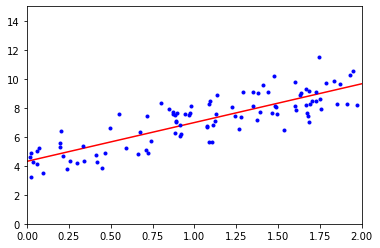

In [5]:
# 모델의 예측 시각화
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X,y, "b.")
plt.axis([0,2,0,15])
plt.show()

- 사이킷런에서 선형회귀 수행

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression()

In [7]:
lin_reg.intercept_, lin_reg.coef_

(array([4.30972087]), array([[2.67468962]]))

In [8]:
lin_reg.predict(X_new)

array([[4.30972087],
       [9.6591001 ]])

- LinearRegression 클래스는 scipy.linalg.lstsq(최소제곱) 함수 사용, 이를 직접 호출할 수 있음
- $\hat \theta = X^+y$ 계산
- $X^+$는 X의 유사역행렬 (무어-펜로즈 Moore=Penrose 역행렬)

In [9]:
# scipy.linalg.lstsq() 호출
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6) #????
theta_best_svd

array([[4.30972087],
       [2.67468962]])

In [10]:
# 유사역행렬 계산
np.linalg.pinv(X_b).dot(y)

array([[4.30972087],
       [2.67468962]])

- 유사역행렬은 특잇값분해(SVD, singular value decomposition)라 부르는 표준행렬분해기법을 사용해 계산됨
- SVD는 훈련세트 행렬 X를 3개의 행렬곱셈 $UΣV^T$로 분해
 - $X^+=V\Sigma^+U^T$
 - $\Sigma^+$를 계산하기 위해 알고리즘이 $\Sigma$를 구한 후, 어떤 낮은 임곗값보다 작은 모든 수를 0으로 바꾼 후 0이 아닌 모든 값을 역수로 치환
 - 마지막으로 만들어진 행렬을 전치
- 정규방정식을 계산하는 것보다 효율적이며, 극단적인 경우도 처리할 수 있음
 - m<n이거나 어떤 특성이 중복돼 행렬 $X^TX$의 역행렬이 없는 특이행렬의 경우 정규방정식이 작동하지 않지만 유사역행렬은 항상 구할 수 있음

### 4.1.2 계산 복잡도
- 정규방정식은 (n+1)x(n+1) 크기가 되는 $X^TX$의 역행렬을 계산 (n은 특성 수)
- 역행렬을 계산하는 계산 복잡도는 일반적으로 $O(n^2.4)$에서 $O(n^3)$사이이며 구현 방법에 따라 차이
 - 특성 수가 두배로 늘어나면 계산시간이 대략 $2^2.4=5.3$에서 $2^3=8$배로 증가
- 사이킷런의 LinearRegression 클래스가 사용하는 SVD방법은 약 $O(n^2)$
 - 특성 수가 두배로 늘어나면 계산시간이 대략 4배로 증가
- 예측 계산 복잡도는 샘플 수와 특성 수에 선형적
 - 예측하려는 샘플 (또는 특성)이 두배로 늘어나면 걸리는 시간도 두배 증가

## 4.2 경사 하강법
- 경사 하강법(GD, gradient descent)은 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘. 비용 함소를 최소화하기 위해 반복해서 파라미터 조정
- 파라미터 벡터 $\theta$에 대해 비용 함수의 현재 그레디언트를 계산하고 그레디언트가 감소하는 방향으로 진행, 그레디언트가 0이 되면 최솟값에 도달
 - 임의의 값으로 시작해 (무작위초기화 random initialization), RMSE와 같은 비용함소가 감소되는 방향으로 진행해 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상시킴
- 중요한 파라미터는 스텝의 크기인 **학습률** 하이퍼파라미터
 - 학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간이 오래 걸림
 - 학습률이 너무 크면 알고리즘을 더 큰 값으로 발산하게 만들어 적절한 해법을 찾지 못함
 - 비용 함수가 그릇과 같은 모양이 아니며 특이한 지형이 있는 경우, 무작위 초기화로 인해 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴하거나 전역 최솟값에 도달하지 못함
- 선형 회귀를 위한 MSE 비용 함수는 지역 최솟값이 없고 하나의 전역 최솟값만 있는 볼록 함수, 연속된 함수로 기울기가 갑자기 변하지 않음 
 - 학습률이 너무 높지 않고 충분한 시간이 주어지면 경사 하강법이 전역 최솟값에 가깝게 접근할 수 있다는 것을 보장
- 특성들의 스케일이 매우 다르면 비용 함수가 길쭉한 모양일 수 있음 - 최솟값에 도달하는 시간이 오래 걸림
 - 경사 하강법을 사용할 때에는 반드시 모든 특성이 같은 스케일을 갖도록 만들어야 함(StandardScaler). 그렇지 않으면 수렴하는 데 오랜 시간이 걸림
- 모델이 가진 파라미터가 많을수록 모델의 파라미터 공간의 차원이 커지고 검색이 더 어려워짐

### 4.2.1 배치 경사 하강법
- 편도함수(partial derivative) : 경사 하강법을 구현할 때 각 모델 파라미터 $\theta_j$에 대해 비용 함수의 그레디언트를 계산하는 것. $\theta_j$가 조금 변경될 때 비용 함수가 얼마나 바뀌는지
1. 파라미터 $\theta_j$에 대한 비용함수의 편도함수 계산 
- $\frac {∂} {∂\theta_j}MSE(θ)=\frac {2}{m} \sum_{i=1}^{m}(θ^Tx^{(i)}-y^{(i)})x_j^{(i)}$
2. 비용함수의 그레디언트 벡터를 한꺼번에 계산  

   <img src = "https://blog.kakaocdn.net/dn/bhaUSq/btq3sud1rLc/Tr5zg1aVim0ouFOYFwnt70/img.png" width="400" height="150">  
 - 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산 (훈련 데이터 전체 사용)
 - 매우 큰 훈련 세트에서 아주 느림
 - 특성 수에 민감하지 않아 수십만 개의 특성에서 선형 회귀를 훈련시킬 때 SVD 분해보다 경사 하강법을 사용하는 편이 훨씬 빠름
 - 그레디언트 벡터가 구해지면 반대 방향인 아래로 가야함
  - 경사 하강법의 스텝 : $\theta^{(next step)} = \theta-η∇_{\theta}MSE(\theta)$



In [11]:
import numpy as np
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화
for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta = theta - eta*gradients

theta

array([[4.30972087],
       [2.67468962]])

- 정규방정식으로 찾은 것과 정확히 같음
- 적절한 학습률을 찾으려면 그리드 탐색 사용, 단 수렴에 너무 오래 걸리는 모델을 막기 위해 반복 횟수 제한
 - 반복 횟수 또한 적절히 설정해야 함
 - 반복 횟수를 아주 크게 지정하고 그레디언트 벡터가 아주 작아지면 (벡터의 노름이 어떤 값-허용오차(ε)-보다 작아지면 경사 하강법이 최솟값에 도달한 것이므로 알고리즘을 중지

> 수렴율
- 비용 함수가 볼록 함수이고 기울기가 급격하게 바뀌지 않는 MSE 비용함수와 같은 경우, 학습률을 고정한 배치 경사 하강법은 결국 최적의 솔루션에 수렴
- 비용 함수의 모양에 따라 달라지겠지만 ε 범위 안에서 최적의 솔루션에 도달하기 위해 1/ε의 반복이 걸릴 수 있음. 오차 ε을 1/10으로 줄이면 알고리즘의 반복은 10배 늘어남

### 4.2.2 확률적 경사 하강법
- 매 스텝에서 전체 훈련 세트를 사용해 그레디언트를 계산하는 배치 경사 하강법
- 확률적 경사 하강법은 매 스텝에서 한 개의 샘플을 무작위로 선택하고 하나의 샘플에 대한 그레이디언트를 계산
 - 매 반복에서 다뤄야 할 데이터가 적어 알고리즘이 빠름
 - 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련 세트도 훈련시킬 수 있음
- 확률적(무작위)이기 때문에 배치 하강법보다 불완전한 알고리즘
 - 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소
 - 알고리즘이 멈출 때 좋은 파라미터가 구해지겠지만 최적치는 아닐 수 있음. 즉 배치 경사 하강법보다 전역 최솟값을 찾을 가능성이 높음
 - 해결방법 : 시작할 때는 학습률을 크게 하고, 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하도록 학습률을 점진적으로 감소시킴
 - 학습 스케쥴 learning schedule : 매 반복에서 학습률을 결정하는 함수


In [12]:
# 학습 스케쥴을 사용한 확률적 경사 하강법의 구현

n_epoches = 50 # epoch는 각 반복, 훈련 세트에서 50번 반복하도록 지정
t0, t1 = 5, 50 # 학습 스케쥴 하이퍼파라미터

def learning_schedule(t):
  return t0/(t+t1)

theta = np.random.randn(2,1) # 무작위 초기화

for epoch in range(n_epoches):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2*xi.T.dot(xi.dot(theta)-yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta-eta*gradients

theta

array([[4.30423012],
       [2.64547493]])

- 샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 에포크에서 여러번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못할 수도 있음
- 알고리즘이 에포크마다 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후 (입력 특성과 레이블을 동일하게 섞어야 함) 차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 방법 사용 가능 
 - SGDClassifier와 SGDRegressor가 사용하는 방법
 - 이렇게 하면 보통 더 늦게 수렴됨

- 사이킷런에서의 SGD방식 선형회귀
 - 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스를 사용 

In [13]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
# max_iter:에포크횟수, tol:한 에포크에서 tol보다 적게 손실이 줄어들 때까지 실행, eta0:학습률, penalty:규제)

sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.36982559]), array([2.77858416]))

- 정규방정식으로 구한 것과 매우 비슷한 값

### 4.2.3 미니배치 경사 하강법
- 각 스텝에서 미니배치라 부르는 임이의 작은 샘플 세트에 대해 그레디언트를 계산
- 행렬 연산에 최적화된 하드위어, 특히 GPU를 사용해서 얻는 성능 향상이 장점
- 미니배치를 어느 정도 크게하면 파라미터 공간에서 SGD보다 덜 불규칙하게 움직이기에 SGD보다 최솟값에 더 가까이 도달
 - 단 선형 회귀가 아니라 지역 최솟값이 문제가 되는 경우 지역 최솟값에서 빠져나오기 더 힘들 수 있음

- 선형 회귀를 사용한 알고리즘 비교. 

|알고리즘|m이 클 때|외부 메모리 학습 지원|n이 클 때|하이퍼 파라미터 수|스케일 조정 필요|사이킷런|
|---|---|---|---|---|---|---|
|정규방정식|빠름|No|느림|0|No|N/A|
|SVD|빠름|No|느림|0|No|LinearRegression|
|배치 경사 하강법|느림|No|빠름|2|Yes|SGDRegressor|
|확률적 경사 하강법|빠름|Yes|빠름|2이상|Yes|SGDRegressor|
|미니배치 경사 하강법|빠름|Yes|빠름|2이상|Yes|SGDRegressor|

- 위 알고리즘들은 훈련결과에 거의 차이가 없음. 모두 매우 비슷한 모델을 만들고 정확한 방식으로 예측


## 4.3 다항 회귀
- 비선형 데이터를 학습하는 데 선형 모델 사용 : 각 특성의 거듭제곱의 새로운 특성으로 추가하고, 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시킴

In [14]:
# 2차방정식으로 비선형 데이터 생성, 잡음 포함시킴
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0], X_poly[0])

[-0.60853607] [-0.60853607  0.37031614]


- X_poly는 원래 특성 X와 특성의 제곱 포함
- 확장된 훈련 데이터 생성됨

In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.11355676]), array([[1.09929233, 0.49644373]]))

- 원래의 함수에서의 계수 및 절편과 비슷한 값 출력됨
- 다항회귀는 특성이 여러개일 때 특성 사이의 관계를 찾을 수 있음
- PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가함

## 4.4 학습 곡선
- 고차 다항 회귀 적용시 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추고자(적합하고자) 함
- 모델이 과대적합 또는 과소적합되었는지 파악하기 위해 모델의 일반화 성능을 추정하기 위한 교차 검증 사용할 수 있음
- 학습 곡선 : 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(훈련 반복)의 함수로 나타내는 그래프
 - 모델의 일반화 성능 추정 가능
 - 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러번 훈련시켜 그래프 생성

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")

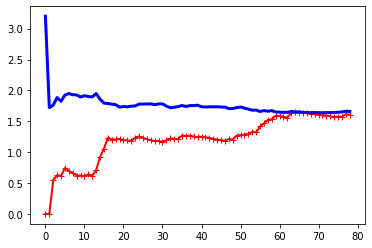

In [18]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- 훈련 데이터에 대한 모델의 성능
 - 훈련 세트에 하나 혹은 두개의 샘플이 있을 땐 모델이 완벽하게 작동 
 - 훈련 세트에 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능해짐
 - 곡선이 어느정도 평편해질 때까지 오차가 계속 상승
- 검증 데이터에 대한 모델의 성능
 - 적은 수의 샘플로 훈련될 때는 일반화될 수 없어 검증 오차가 초기에 매우 큼
 - 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소
- 과소적합 모델

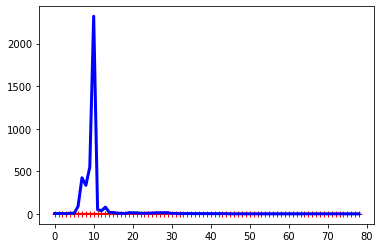

In [28]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이의 공간 : 훈련 데이터에서의 모델 성능이 검증 데이터에서 훨씬 낮다는 뜻, 과대 적합 모델의 특징
- 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐
- 과대적합 모델


> 편향/분산 트레이드오프
- 편향 : 일반화 오차 중 편향은 잘못된 가정으로 인한 것. 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉬움
- 분산 : 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타남. 자유도가 높은 모델(ex.고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있음
- 줄일 수 없는 오차(irreducible error) : 데이터 자체에 있는 잡음 때문에 발생. 오차를 줄이기 위해서는 데이터에서 잡음을 제거해야 함

## 4.5 규제가 있는 선형 모델
- 모델의 가중치를 제한함으로써 규제를 가하는 선형 회귀 모델

### 4.5.1 릿지 회귀
- 릿지 회귀 (티노호프 규제) 
 - 규제가 추가된 선형회귀
 - 규제항 $α\sum_{i=1}^{n}\theta_i^2$이 비용 함수에 추가
 - 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력
 - 규제항은 훈련하는 동안에만 비용 함수에 추가, 모델 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가 #?
- 릿지 회귀의 비용함수 $J(\theta)=MSE(\theta)+α\frac{1}{2}\sum_{i=1}^{n}\theta_i^2$
 - 하이퍼파라미터 α는 모델을 얼마나 많이 규제할지 조절. α=0이면 선형 회귀와 같음. α가 아주 크면 모든 가중치가 거의 0에 가까워지고 데이터의 평균을 지나는 수평선이 됨.
 - 편항 $\theta_0$는 규제되지 않음
 - $w$를 특성의 가중치 벡터 $\theta_1$에서 $\theta_n$라고 정의하면 규제항은 $\frac{1}{2}(||w||_1)^2$
 - 경사 하강법에 적용시 MSE그레디언트 벡터에 αw를 더하면 됨
 - 릿지 회귀를 계산하기 위한 정규방정식
 - $ \hat\theta = (X^TX+αA)^{-1} X^Ty $


In [29]:
# 정규방정식을 사용한 릿지 회귀
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.30541005]])

In [30]:
# 확률적 경사 하강법을 이용한 릿지 회귀
sgd_reg = SGDRegressor(penalty="L2") # L2 : sgd가 비용 함수에 가중치 벡터의 l_2 노름의 제곱을 2로 나눈 규제항을 추가하게 함
sgd_reg.fit(X,y)
sgd_reg.predict([[1.5]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([5.28842011])

### 4.5.2 라쏘 회귀
- 라쏘 (Lasso, least absolute shrinkage and selection operater)
- 비용함수에 규제항을 더하지만, $l_2$노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 $l_1$ 노름을 사용
- 라쏘 회귀의 비용함수 $J(\theta)=MSE(\theta)+α\frac{1}{2}\sum_{i=1}^{n}|\theta_i|$
- 덜 중요한 특성의 가중치를 제거하려고 함 (가중치가 0이 됨)
- 특성 선택을 하고 희소 모델을 만듬 (0이 아닌 특성의 가중치가 적음)
- 라쏘를 사용할 때 경사 하강법이 최적점 근처에서 진동하는 것을 막으려면 훈련하는 동안 점진적으로 학습률을 감소시켜야 함
  - $\theta_i=0$(i=1,2,...,n)일 때 미분 가능하지 않지만, 서브 그레디언트벡터 g를 사용하면 경사 하강법을 적용하는 데 문제가 없음
 - 경사 하강법을 위한 라소 회귀의 서브그레이디언트 벡터   
 <img src = "https://yganalyst.github.io/assets/images/ML/chap3/lasso2.png" width="500" height="80">  

In [31]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1) # 혹은 SGDRegressor(penalty="l1")
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([5.25973022])

### 4.5.3 엘라스틱넷
- 엘라스틱넷은 릿지 회귀와 랏소 회귀를 절충한 모델
- 규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용, 혼합 정도는 혼합 비율 r을 사용해 조절
 - r=0이면 릿지 회귀, r=1이면 라쏘 회귀와 같음
- 엘라스틱넷 비용함수 $J(\theta)=MSE(\theta)+rα\frac{1}{2}\sum_{i=1}^{n}|\theta_i|+\frac{1-r}{2}α\sum_{i=1}^{n}\theta_i^2$


> 회귀 적용
- 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야 함
- 릿지가 기본, 쓰이는 특성이 몇 개뿐이라고 의심되면 불필요한 특성의 가중치를 0으로 만들어주는 라쏘나 엘라스틱넷이 나음
- 특성 수가 훈련 샘플 수보다 많거나 특성 몇개가 강하게 연관되어 있을 때는 라쏘보다는 엘라스틱넷 선호

### 4.5.4 조기 종료
- 조기 종료 : 검증 에러가 최솟값에 도달하면 바로 훈련을 중지
 - 확률적 경사하강법이나 미니배치 경사하강법의 경우 검증 에러가 일정 시간 동안 최솟값보다 클 때 학습을 멈추는 것이 좋음
- 에포크가 진행됨에 따라 예측 에러가 줄어들다가, 다시 상승  > 모델이 훈련 데이터에 과대적합되기 시작하는 것을 의미


In [33]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 훈련을 이어서 진행
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

- warm_start=True 지정시 fit()메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감

## 4.6 로지스틱 회귀
- 로지스틱 회귀(로짓 회귀) : 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용됨
- 이진분류기 : 추정 확률이 50%가 넘으면 모델이 해당 클래스에 속한다고 예측 (레이블이 '1'인 양성 클래스), 아니면 클래스에 속하지 않는다고 예측 (레이블이 '0'인 음성클래스)

### 4.6.1 확률 추정
- 로지스틱 회귀모델은 입력 특성의 가중치합을 계산하고 편향을 더함. 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력
- 로지스틱 회귀 모델의 확률 추정(벡터 표현식)
 - $\hat p=h_\theta(x)=σ(θ^Tx)$ : 로지스틱 회귀모델의 샘플 x가 양성 클래스에 속할 확률
 - 로지스틱 σ은 0과 1 사이의 값을 출력하는 시그모이드 함수 (S자 형태)
- $θ^Tx$, 즉 로짓logit, 로그-오즈, logit(p)=log(p/(1-p))가 양수일 때 1이라고 예측, 음수일 때 0이라고  예측

### 4.6.2 훈련과 비용 함수
- 하나의 훈련 샘플에 대한 비용함수 
 - <img src = "https://yganalyst.github.io/assets/images/ML/chap3/logistic4.png" width="250" height="50">
 - 모델이 양성 샘플을 0에 가까운 확률로 추정하거나 음성 샘플을 1에 가까운 확률로 추정하면 비용이 증가
- 전체 훈련 세트에 대한 비용함수는 모든 훈련 샘플의 비용을 평균한 로그 손실(log loss)
 - 로지스틱 회귀의 비용함수 (로그손실)
 - $J(\theta)= -\frac{1}{m}$$\sum_{i=1}^{m}[y^{(i)}log(\hat p^{(i)})+(1-y^{(i)})log(1-\hat p^{(i)})]$
- 로그손실은 최솟값을 계산하는 알려진 해가 없지만 볼록 함수이므로 경사 하강법(또는 어떤 다른 최적화 알고리즘)이 전역 최솟값을 찾는 것을 보장(학습률이 너무 크지 않고 충분히 기다릴 시간이 있다면)
 - 로지스틱 비용 함수의 편도함수
 - $\frac {∂} {∂\theta_j}J(θ)=\frac {1}{m} \sum_{i=1}^{m}(\sigma(θ^Tx^{(i)})-y^{(i)})x_j^{(i)}$
 - 각 샘플에 대해 예측 오차를 계산하고 j번째 특성값을 곱해서 모든 훈련 샘플에 대해 평균을 냄
 - 모든 편도함수를 포함한 그레디언트 벡터를 만들어 배치 경사 알고리즘을 사용할 수 있음



### 4.6.3 결정 경계
- 붓꽃 데이터셋을 사용, 꽃잎의 넓이를 기반으로 Iris-Versicolor 종을 감지하는 분류기 생성

In [34]:
# 데이터 로드
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [35]:
X=iris["data"][:,3:] # 꽃잎의 너비
y=(iris["target"]==2).astype(np.int) # Iris-Virginica면 1, 그렇지 않으면 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


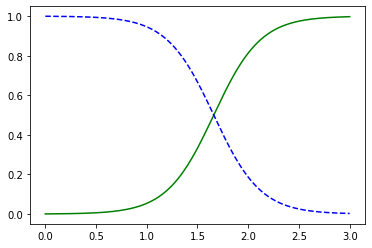

In [38]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)

X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:,0], "b--", label="Not Iris virginica")
plt.show()

- Iris-Verginica의 꽃잎 넓이는 1.4~2.5cm, 다른 붓꽃은 0.1~1.8cm에 분포해 약간의 중첩되는 부분 존재
- 클래스를 예측하려고 하면 가장 가능성 높은 클래스를 반환, 양쪽의 확률이 똑같이 50%가 되는 1.6cm근방에서 결정 경계decision boundary가 생성됨

In [40]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

- 다른 선형 모델처럼 로지스틱 회귀모델도 l1, l2페널티 사용해 규제 가능, 사이킷런은 l2페널티를 기본으로 함


### 4.6.4 소프트맥스 회귀
- 소프트맥스 회귀, 다항 로지스틱 회귀 : 로지스틱 회귀모델이 여러개의 이진분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화됨
- 샘플 x가 주어지면 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 $s_k(x)$를 계산, 그 점수에 소프트맥스 함수(또는 정규화된 지수함수, normalized exponential function)를 적용하여 각 클래스의 확률을 추정
 - $s_k(x)$를 계산하는 식은 선형 회귀 예측을 위한 식과 매우 비슷
 - 클래스 k에 대한 소프트맥스 점수 $s_k(x)=(\theta^{(k)})^Tx$
 - 각 클래스는 자신만의 파라미터 벡터 $\theta^{(k)}$가 있으며, 이 벡터들은 파라미터 행렬 (parametric matrix)에 행으로 저장됨
- 샘플 x에 대해 각 클래스의 점수가 계산되면 소프트맥스함수를 통과시켜 클래스에 속할 확률 $\hat p_k$을 추정
 - 소프트맥스 회귀 분류기의 예측 <img src = "https://dojinkimm.github.io/assets/imgs/ml/handson_4_21.png" width="400" height="100">
 - argmax 연산은 함수를 최대화하는 변수의 값을 반환. 이 식에서는 추정확률 $\sigma(s(x))_k$가 최대인 k값을 반환
- 훈련 : 모델이 타깃 클래스에 대해서는 높은 확률을(다른 클래스에 대해서는 낮은 확률을 추정하도록) 만드는 것이 목적
 - 크로스 엔트로피 비용함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 적절 - 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용됨
 - 크로스 엔트로피 비용 함수 $J(Θ)=\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_k^{(i)}log(\hat p_k^{(i)})$
 - $y_k^{(i)}$는 i번째 샘플이 클래스 k에 속할 타깃 확률
 - 두개의 클래스가 있을때(K=2) 비용 함수는 로지스틱 회귀의 비용 함수와 같음
 - 클래스 k에 대한 크로스 엔트로피의 그레디언트 벡터를 계산해 비용 함수를 최소화하기위한 파라미터 행렬 Θ를 찾기 위해 경사 하강법(또는 다른 최적화 알고리즘) 사용 가능
- 사이킷런의 multi_class 매개변수를 "multinomial"로 바꾸면 소프트맥스 회귀 사용 가능. 기본적으로 l2규제가 적용됨



In [41]:
X=iris["data"][:,(2,3)] # 꽃잎 길이, 너비
y=iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
# solver : 소프트맥스 회귀 지원하는 알고리즘 'lbfgs' 지정, C : rbwp whwjf
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [43]:
softmax_reg.predict([[5,2]])

array([2])

In [44]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])